Data downloaded from Kaggle "Real estate price prediction": https://www.kaggle.com/quantbruce/real-estate-price-prediction

Data:
- Transaction date (purchase)
- House age
- Distance to the nearest MRT station (metric not defined)
- Amount of convenience stores
- Location (latitude and longitude)
- House price of unit area 





In [ ]:
!pip install hdbscan

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
from scipy.stats import shapiro     #normality test
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from scipy.spatial import distance
from sklearn.decomposition import PCA
from yellowbrick.regressor import ResidualsPlot 
from mpl_toolkits.mplot3d import Axes3D   #plot 3D
from hdbscan import HDBSCAN
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
import statsmodels.stats.api as sms
from sklearn.cluster import KMeans
from sklearn import metrics

#Pre-processing

- Reading dataset 

In [3]:
# reading dataset 
data = pd.read_csv("./Real estate.csv")

print(data.info(),
      '\n___________duplicated()___________\n', data.duplicated().any(), 
      '\n___________isnull()___________\n', data.isnull().sum()
      )
data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   No                                      414 non-null    int64  
 1   X1 transaction date                     414 non-null    float64
 2   X2 house age                            414 non-null    float64
 3   X3 distance to the nearest MRT station  414 non-null    float64
 4   X4 number of convenience stores         414 non-null    int64  
 5   X5 latitude                             414 non-null    float64
 6   X6 longitude                            414 non-null    float64
 7   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 26.0 KB
None 
___________duplicated()___________
 False 
___________isnull()___________
 No                                        0
X1 transaction date           

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3


Dropping non useful columns

In [4]:
#dropping columns
columns_to_drop = ['X1 transaction date', 'No']
data = data.drop(columns_to_drop, axis=1)
data.head(3)

,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,32.0,84.87882,10,24.98298,121.54024,37.9
1,19.5,306.59470,9,24.98034,121.53951,42.2
2,13.3,561.98450,5,24.98746,121.54391,47.3


#Exporatory Data Analysis

In [5]:
#normality Shapiro-Wilk test function
def normality_test(data):
  stat, p_value = shapiro(data)    #Shapiro-Wilk test
  alpha = 0.05

  if p_value > alpha:
    print('Normality test: Gaussian')  #fail in reject H0 (null hypothesis H0: follow normal distribution)
  else:
    print('Normality test: Non Gaussian') #reject H0 (alternative hypothesis H1: does not follow normal distribution)

Data distribution (2D and 3D plots)

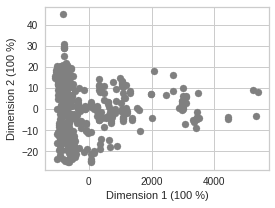

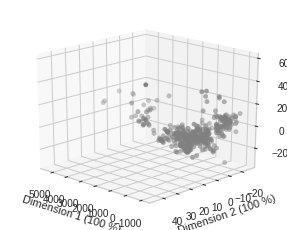

In [6]:
#data plot (2D and 3D)
def data_scatter(data_, pca, n_dim, ax, color):
  if(n_dim == 2):
    plt.scatter(data_[:,0], data_[:,1], color=color)    #plot 2D
  else:
    ax.scatter(data_[:,0], data_[:,1], data_[:,2], color=color)  #plot 3D
    ax.set_zlabel('Dimension 3 (%.f %%)' % (round(pca.explained_variance_ratio_.cumsum()[2], 2)*100)) #third principal component
  plt.xlabel('Dimension 1 (%.f %%)' % (round(pca.explained_variance_ratio_.cumsum()[0], 2)*100)) #first principal component
  plt.ylabel('Dimension 2 (%.f %%)' % (round(pca.explained_variance_ratio_.cumsum()[1], 2)*100)) #second principal component
  

#PCA: dimension reduction
pca = PCA()
data_ = pca.fit_transform(data)

#2D data plot
ax = plt.figure(figsize=(4, 3))
data_scatter(data_, pca, 2, ax, 'grey')

#3D data plot
fig = plt.figure(figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=20, azim=134)
data_scatter(data_, pca, 3, ax, 'grey')

Features distribution (Histogram)

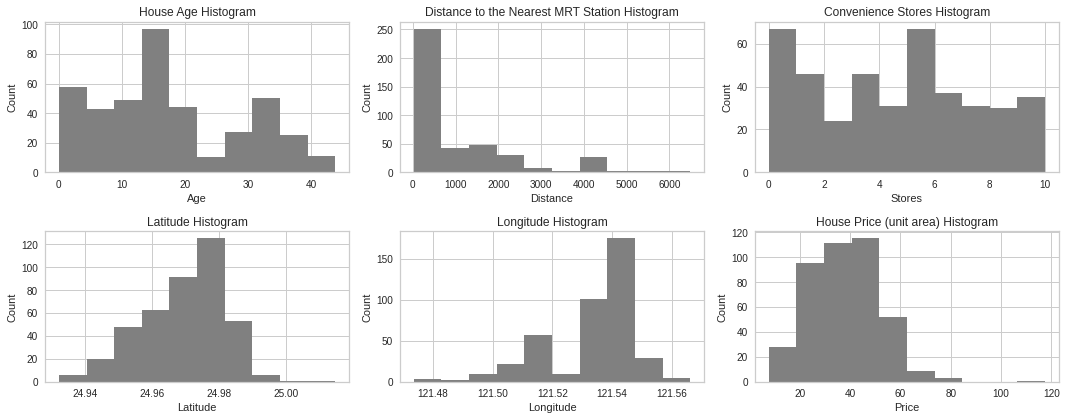

In [7]:
def hist_feature(data, x_ax, title, color):
  plt.hist(data, color=color)
  plt.xlabel(x_ax)
  plt.ylabel('Count')
  plt.title(title)

plt.figure(figsize=(15,6))

plt.subplot(231)
hist_feature(data['X2 house age'], 'Age', 'House Age Histogram', 'grey')

plt.subplot(232)
hist_feature(data['X3 distance to the nearest MRT station'], 'Distance', 'Distance to the Nearest MRT Station Histogram', 'grey')

plt.subplot(233)
hist_feature(data['X4 number of convenience stores'], 'Stores', 'Convenience Stores Histogram', 'grey')

plt.subplot(234)
hist_feature(data['X5 latitude'], 'Latitude', 'Latitude Histogram', 'grey')

plt.subplot(235)
hist_feature(data['X6 longitude'], 'Longitude', 'Longitude Histogram', 'grey')

plt.subplot(236)
hist_feature(data['Y house price of unit area'], 'Price', 'House Price (unit area) Histogram', 'grey')

plt.tight_layout()

Box-plot

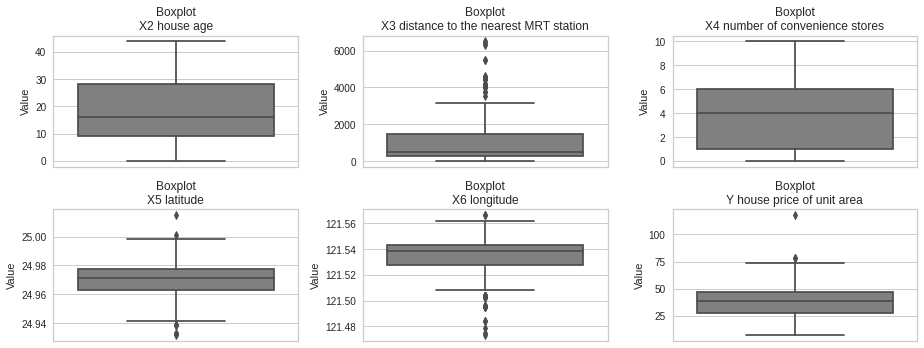

In [8]:
plt.figure(figsize=(13,5))

grid = [231, 232, 233, 234, 235, 236]
for feat, grd in zip(data, grid):
  plt.subplot(grd)
  sns.boxplot(y=data[feat], color='grey')
  plt.ylabel('Value')
  plt.title('Boxplot\n%s'%feat)
plt.tight_layout()

Dropping outliers
- Outlier defined by HDBSCAN clustering

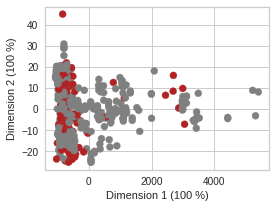

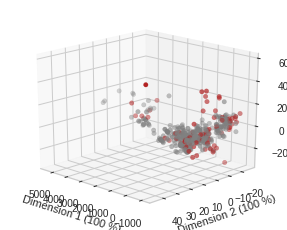

In [9]:
#HDBSCAN clustering
hdb = HDBSCAN(min_cluster_size=2).fit(data)
hdb_pred = hdb.labels_

#data color
col_cl = ['grey'] * len(hdb_pred)

#defining outlier
index_outlier = []
for i, out in zip(range(len(data)), hdb_pred):
  if out == -1:               
    index_outlier.append(i)   #index of data defined as outlier
    col_cl[i] = 'firebrick'       #outlier defined as black


#data visualization - 2D
ax = plt.figure(figsize=(4, 3))
data_scatter(data_, pca, 2, ax, col_cl)

#3D data plot
fig = plt.figure(figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=20, azim=134)
data_scatter(data_, pca, 3, ax, col_cl)


Data describe: without outlier defined by hdbscan


,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
count,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000
mean,17.052819,1164.679430,3.946588,24.968309,121.532481,36.928190
std,10.893199,1304.871242,2.886256,0.012306,0.016118,12.875854
min,0.000000,23.382840,0.000000,24.938850,121.473530,11.200000
25%,8.900000,289.324800,1.000000,24.962990,121.518120,26.600000
50%,15.700000,533.476200,4.000000,24.969450,121.538420,38.100000
75%,26.600000,1712.632000,6.000000,24.977440,121.543200,45.700000
max,41.300000,6488.021000,10.000000,25.001150,121.566270,73.600000


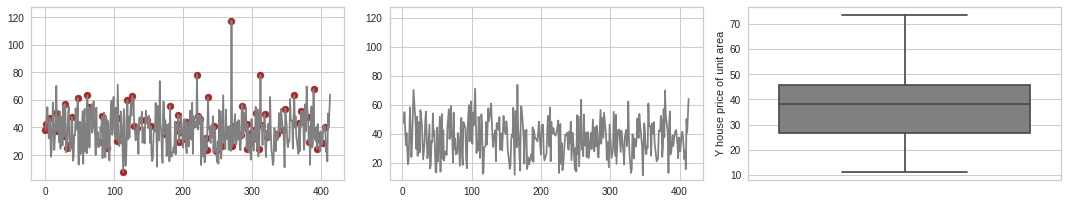

In [10]:
#visualizing new data (without outliers)
plt.figure(figsize=(15, 3))

#plot old data
plt.subplot(131)
plt.plot(data['Y house price of unit area'], color='grey')
plt.ylim(top=np.max(data['Y house price of unit area'])+10)
plt.scatter(index_outlier, data.loc[index_outlier]['Y house price of unit area'], color='firebrick')

#defining new data
new_data = data.drop(index_outlier)

plt.subplot(132)
plt.plot(new_data['Y house price of unit area'], color='grey')
plt.ylim(top=np.max(data['Y house price of unit area'])+10)

plt.subplot(133)
sns.boxplot(y=new_data['Y house price of unit area'], color='grey')

plt.tight_layout()


print('\nData describe: without outlier defined by hdbscan')
new_data.describe()

Normality test

In [11]:
print('Assumption of normality')
normality_test(new_data)

Assumption of normality
Normality test: Non Gaussian


Correlation matrix
- Spearman (non-parametric method) due the normality test 

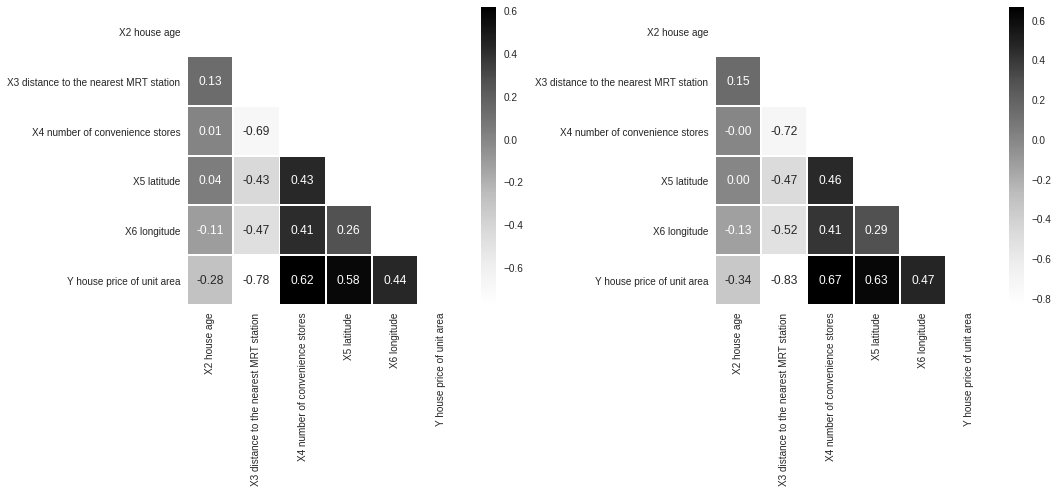

In [12]:
#correlation matrix
mask = np.triu(np.ones_like(data.corr())) 

plt.figure(figsize=(15, 7))

plt.subplot(121)
sns.heatmap(data.corr(method='spearman'), annot=True, linewidths=.9, fmt= '.2f', cmap='Greys', mask=mask) #the non parametric method spearman rank is used

plt.subplot(122)
sns.heatmap(new_data.corr(method='spearman'), annot=True, linewidths=.9, fmt= '.2f', cmap='Greys', mask=mask) #the non parametric method spearman rank is used

plt.tight_layout()

In [13]:
old_data = data
data = new_data.reset_index()

Feature comparison (dependence)
- dependent and independent features

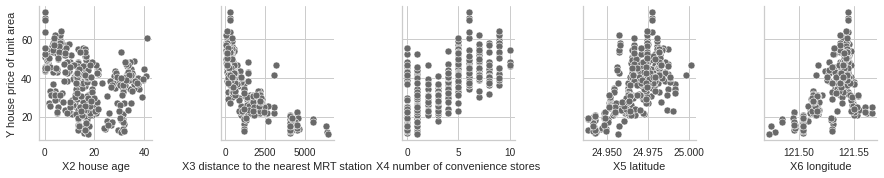

In [14]:
sns.pairplot(data, y_vars='Y house price of unit area', palette = sns.set_palette(['#696969']),
             x_vars=['X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude', 'X6 longitude']);

**outliers analysis**

Outliers: 77


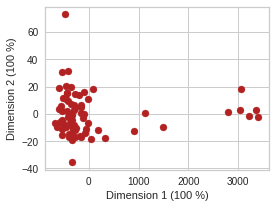

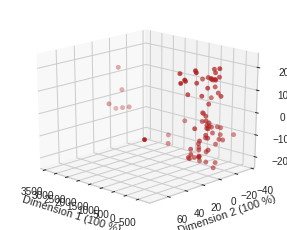

In [15]:
outlier = old_data.loc[index_outlier]
print('Outliers:', len(outlier))

#PCA: dimension reduction
pca = PCA()
data_out = pca.fit_transform(outlier)

#data visualization - 2D
ax = plt.figure(figsize=(4, 3))
data_scatter(data_out, pca, 2, ax, 'firebrick')

#3D data plot
fig = plt.figure(figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=20, azim=134)
data_scatter(data_out, pca, 3, ax, 'firebrick')

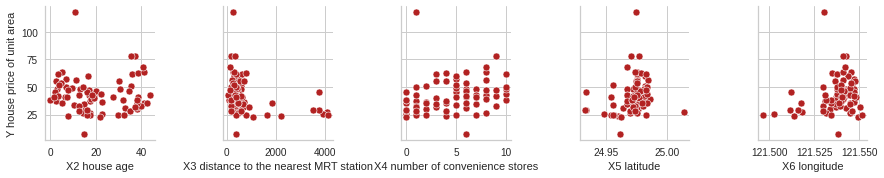

In [16]:
sns.pairplot(outlier, y_vars='Y house price of unit area', palette = sns.set_palette(['firebrick']),
             x_vars=['X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude', 'X6 longitude']);

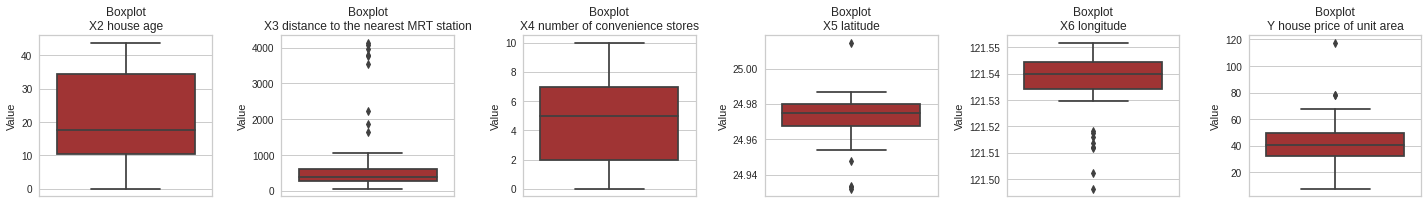

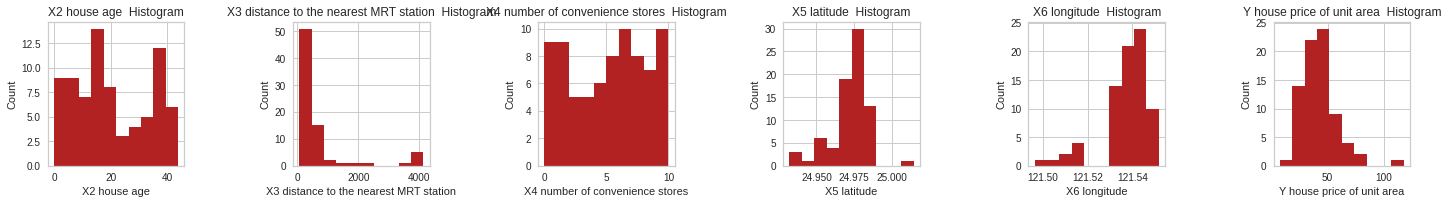

In [17]:
plt.figure(figsize=(20,3))
for feat, grid in zip(outlier, range(161,167)):
  plt.subplot(grid)
  sns.boxplot(y=outlier[feat], color='firebrick')
  plt.ylabel('Value')
  plt.title('Boxplot\n%s'%feat)

plt.tight_layout()
plt.show()


plt.figure(figsize=(20,3))
for _, grd in zip(outlier, range(161,167)):
  plt.subplot(grd)
  hist_feature(outlier[_], _, ('%s  Histogram' % _), 'firebrick')

plt.tight_layout()
plt.show()


k-means clustering

In [18]:
sil_score = pd.DataFrame(columns=['k', 'score'])

clus_color_array = []
kmeans_pred_pack = []
for k in range(2, np.sqrt(len(outlier)).astype(int)):
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans_pred = kmeans.fit_predict(outlier) 
  kmeans_pred_pack.append(kmeans_pred)

  #prediction color
  clus_color = cm.Spectral(kmeans_pred.astype(float) / np.max(kmeans_pred))
  clus_color_array.append(clus_color)
  
  #silhouette score
  sil_score.loc[k-2, 'k'] = k
  sil_score.loc[k-2, 'score'] = metrics.silhouette_score(outlier, kmeans_pred)

sil_score = sil_score.sort_values(by='score', ascending=False).reset_index(drop=True).head(3)
sil_score

,k,score
0,2,0.886574
1,3,0.838602
2,4,0.642623


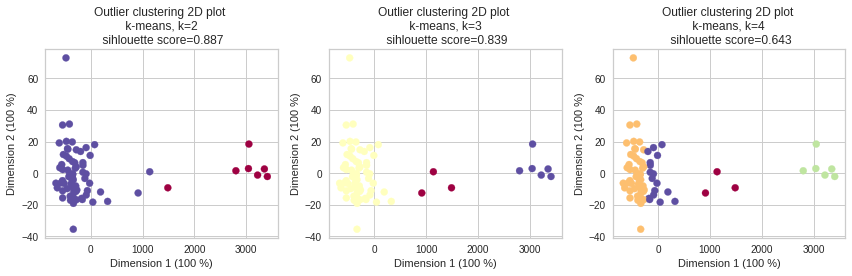

In [19]:
ax = plt.figure(figsize=(12, 4))

for i, k, grid in zip(range(3), sil_score['k'], range(131, 134)):  
  #plot kmeans - 2D  
  plt.subplot(grid)
  data_scatter(data_out, pca, 2, ax, clus_color_array[i].tolist())
  plt.title('Outlier clustering 2D plot \n k-means, k=%d \n sihlouette score=%.3f' % (k, sil_score.loc[i, 'score']))

plt.tight_layout()
plt.show()

In [20]:
#color of the clustering with max silhouette score
clus_color_array = pd.DataFrame(clus_color_array[0]).drop_duplicates().reset_index(drop=True)

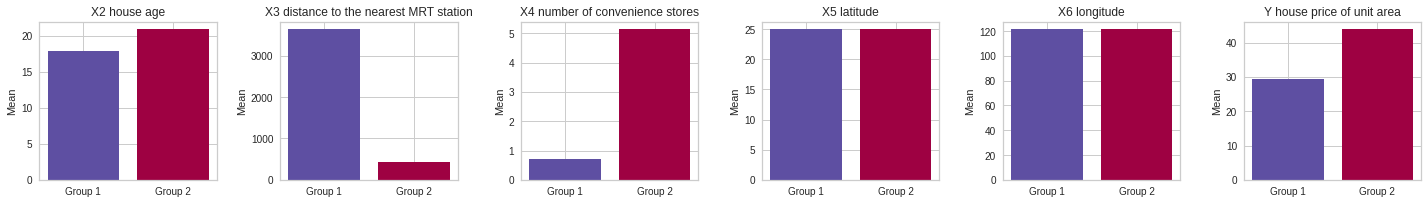

In [21]:
outlier['Group'] = kmeans_pred_pack[0]

frame = outlier.groupby('Group').mean()

plt.figure(figsize=(20,3))
for _, grid in zip(frame, range(161, 167)):
  plt.subplot(grid)
  plt.bar(['Group 1', 'Group 2'], frame[_], color = [list(clus_color_array.loc[0]), list(clus_color_array.loc[1])])
  plt.title(_)
  plt.ylabel('Mean')

plt.tight_layout()

#Linear Regression

**Prediction**

MODEL WITHOUT OUTLIERS
- Train-test split
- Cross-validation

In [22]:
#dropping columns
X = data.loc[:,'X2 house age' : 'X6 longitude']
y = data.loc[:,'Y house price of unit area']

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#Linear regression model
reg = LinearRegression()

#linear regression with train-test split
reg_fit = reg.fit(X_train, y_train)
price_predict = reg_fit.predict(X_test)

#linear regression with cross-validation
price_predict_cv = cross_val_predict(reg, X, y, cv=10)

#regression coefficients
index_reg = ['Intercept', 'X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X4 number of convenience stores', 'X6 longitude']
pd.DataFrame(data=np.append(reg.intercept_, reg.coef_), index=index_reg, columns=['values']).transpose()

,Intercept,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X4 number of convenience stores,X6 longitude
values,-6945.654033,-0.396326,-0.003931,1.343136,273.142628,1.385861


MODEL WITH OUTLIERS

In [23]:
#dropping columns
X_out = old_data.loc[:,'X2 house age' : 'X6 longitude']
y_out = old_data.loc[:,'Y house price of unit area']

#Train-test split
X_train_out, X_test_out, y_train_out, y_test_out = train_test_split(X_out, y_out, test_size=0.33, random_state=42)

#Linear regression model
reg_out = LinearRegression()

#linear regression with train set
reg_fit_out = reg_out.fit(X_train, y_train) 
price_predict_out = reg.predict(X_test_out)

#liinear regression with cross-validation
price_predict_cv_out = cross_val_predict(reg_out, X_out, y_out, cv=10)

#regression coefficients
index_reg = ['Intercept', 'X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X4 number of convenience stores', 'X6 longitude']
pd.DataFrame(data=np.append(reg_out.intercept_, reg_out.coef_), index=index_reg, columns=['values']).transpose()


,Intercept,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X4 number of convenience stores,X6 longitude
values,-6945.654033,-0.396326,-0.003931,1.343136,273.142628,1.385861


Predictions plot

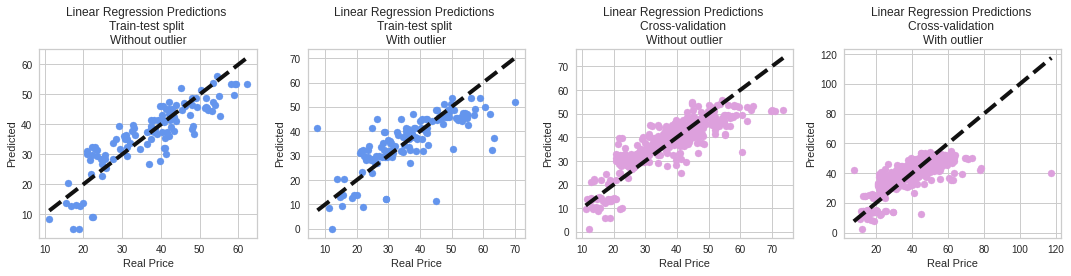

In [24]:
#Predictions plot
plt.figure(figsize=(15,4))

def plot_regression(real, predicted, color, title):
  plt.scatter(real, predicted, color=color)
  plt.plot([real.min(), real.max()], [real.min(), real.max()], 'k--', lw=4)
  plt.xlabel('Real Price')
  plt.ylabel('Predicted')
  plt.title(title)


#Real price vs train-test predictions plot (without outliers)
plt.subplot(141)
plot_regression(y_test, price_predict, 'cornflowerblue', 'Linear Regression Predictions \nTrain-test split \nWithout outlier')

#Real price vs train-test predictions plot (with outliers)
plt.subplot(142)
plot_regression(y_test_out, price_predict_out, 'cornflowerblue', 'Linear Regression Predictions \nTrain-test split \nWith outlier')

#Real price vs cross-validation (all dataset) predictions plot (without outliers)
plt.subplot(143)
plot_regression(y, price_predict_cv, 'plum', 'Linear Regression Predictions \nCross-validation \nWithout outlier')

#Real price vs cross-validation (all dataset) predictions plot (with outliers)
plt.subplot(144)
plot_regression(y_out, price_predict_cv_out, 'plum', 'Linear Regression Predictions \nCross-validation \nWith outlier')


plt.tight_layout()
plt.show()

**Prices plot (data without outliers)**
- Real, train-test split and cross-validation (same data set)

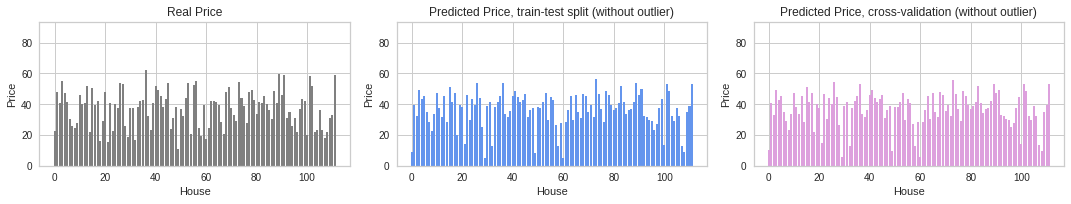

In [25]:
#Prices plot
max_pred = np.maximum(price_predict.max(), price_predict_cv.max())   #max price between predicteds price
max_price = np.maximum(y_train.max(), max_pred)   #max price between real and predicteds price
def real_plot(x_ax, y_ax, title, color):
  #plt.tight_layout()
  plt.bar(x_ax, y_ax, color=color)
  plt.ylim(top=max_price+20)
  plt.title(title)
  plt.ylabel('Price')
  plt.xlabel('House')

#Prices comparison plot (real and predicteds)
plt.figure(figsize=(20,3))

#Real price plot
plt.subplot(141)
real_plot(np.arange(len(y_test)), y_test, 'Real Price', 'grey')

#Predicted price plot
plt.subplot(142)
real_plot(np.arange(len(price_predict)), price_predict, 'Predicted Price, train-test split (without outlier)', 'cornflowerblue')

#Predicted price plot (all dataset)
plt.subplot(143)
real_plot(np.arange(len(y_test)), price_predict_cv[y_test.index], 'Predicted Price, cross-validation (without outlier)', 'plum')

plt.tight_layout()
plt.show()

Predictions comparison
- Plot
  - Real vs cross-validation
  - Real vs cross-validation vs train-test split (same split)
- Distance
  - Prediction distance in general (real vs cross-validation and real vs train-test split) 
  - Prediction distance between real, cross-validation and train-test split (same split / houses in common) 

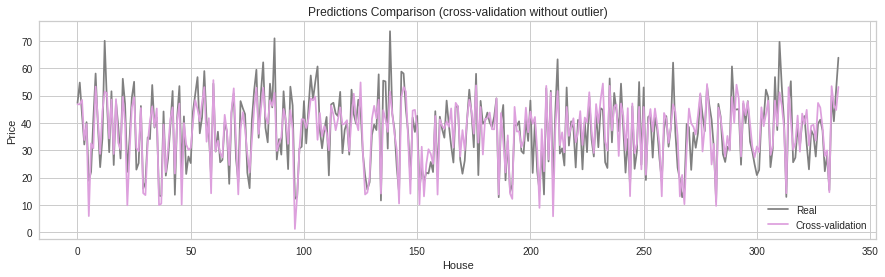

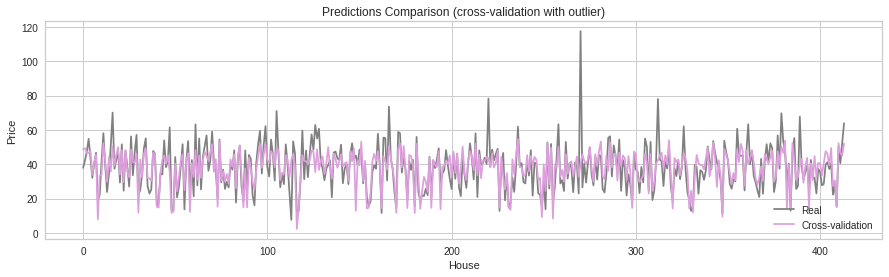

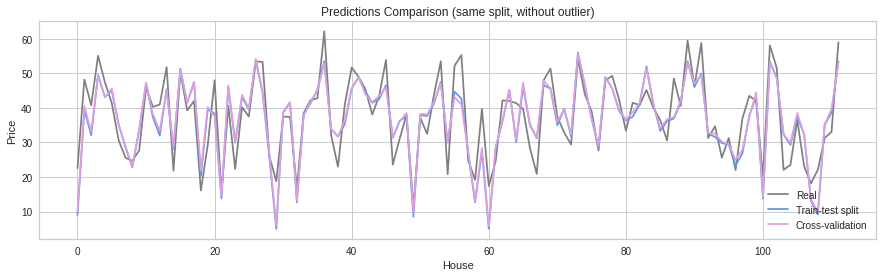

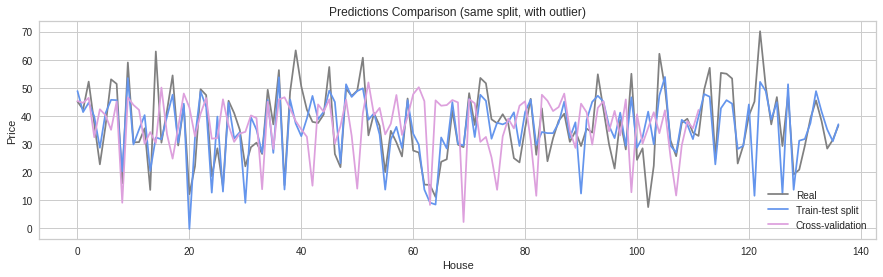


Euclidean distance between prices (in general)
- Real vs train-test: 63.428
- Real vs cross-validation (without outlier): 122.280
- Real vs cross-validation (with outlier): 183.061

Euclidean distance between prices (same split, without outlier)
- Real vs train-test: 63.428
- Real vs cross-validation (all dataset): 63.321

Euclidean distance between prices (same split, with outlier)
- Real vs train-test: 98.270
- Real vs cross-validation (all dataset): 164.565


In [39]:
#Predictions comparison plot

#real vs cross-validation (without outlier)
plt.figure(figsize=(15,4))
plt.plot(np.array(y), color='grey', label='Real')
plt.plot(price_predict_cv, color='plum', label='Cross-validation')
plt.xlabel('House')
plt.ylabel('Price')
plt.title('Predictions Comparison (cross-validation without outlier)')
plt.legend(loc=4)
plt.show()

#real vs cross-validation (with outlier)
plt.figure(figsize=(15,4))
plt.plot(np.array(y_out), color='grey', label='Real')
plt.plot(price_predict_cv_out, color='plum', label='Cross-validation')
plt.xlabel('House')
plt.ylabel('Price')
plt.title('Predictions Comparison (cross-validation with outlier)')
plt.legend(loc=4)
plt.show()

#real vs train-test vs cross-validation, without outlier
plt.figure(figsize=(15,4))
plt.plot(np.array(y_test), color='grey', label='Real')
plt.plot(price_predict, color='cornflowerblue', label='Train-test split')
plt.plot(price_predict_cv[y_test.index], color='plum', label='Cross-validation')
plt.xlabel('House')
plt.ylabel('Price')
plt.title('Predictions Comparison (same split, without outlier)')
plt.legend(loc=4)
plt.show()

#real vs train-test vs cross-validation, with outlier
plt.figure(figsize=(15,4))
plt.plot(np.array(y_test_out), color='grey', label='Real')
plt.plot(price_predict_out, color='cornflowerblue', label='Train-test split')
plt.plot(price_predict_cv_out[y_test.index], color='plum', label='Cross-validation')
plt.xlabel('House')
plt.ylabel('Price')
plt.title('Predictions Comparison (same split, with outlier)')
plt.legend(loc=4)
plt.show()


#Predictions distance (in general)
print('\nEuclidean distance between prices (in general)')
print('- Real vs train-test: %.3f' % distance.euclidean(y_test, price_predict))
print('- Real vs cross-validation (without outlier): %.3f' % distance.euclidean(y, price_predict_cv))
print('- Real vs cross-validation (with outlier): %.3f' % distance.euclidean(y_out, price_predict_cv_out))


#Predictions comparison plot
#Predictions distance (cross validation and train-test split set are the same), without outlier
print('\nEuclidean distance between prices (same split, without outlier)')
print('- Real vs train-test: %.3f' % distance.euclidean(y_test, price_predict))
print('- Real vs cross-validation (all dataset): %.3f' % distance.euclidean(y_test, price_predict_cv[y_test.index]))


#Predictions comparison plot
#Predictions distance (cross validation and train-test split set are the same), with outlier 
print('\nEuclidean distance between prices (same split, with outlier)')
print('- Real vs train-test: %.3f' % distance.euclidean(y_test_out, price_predict_out))
print('- Real vs cross-validation (all dataset): %.3f' % distance.euclidean(y_test, price_predict_cv_out[y_test.index]))

**Evaluation**

R2: Coefficient of determination R2
- proximity of the data to the regression line - measure variability proportion in y that can be explained from x
- 0: model does not explain the variability of response data around its mean
- 1: model explains the variability of response data around its mean

MAE: mean absolute error
- redidual points of every data point
- small values suggests that the model is great at prediction
- large values suggests that the model may have trouble in certain areas
- 0: the model is a perfect predictor


MSE: mean square error
- square of redidual points (error) of every data point

In [27]:
#function to determine R2 coefficient, MAE and MSE measures
def eval_r2_mae_mse(xtrain, ytrain, ytest, y, predict, predict_cv):
  #train-test split
  print('Train-test split \n',
      'Coefficient of determination R2 (train): %.3f \n' % reg.score(xtrain, ytrain),
      'Coefficient of determination R2 (test): %.3f \n' % r2_score(ytest, predict),
      'Mean Absolute Error (train-test split): %.2f \n' % (sum(abs(ytest - predict)) / len(ytest)),    
      'Mean Square Error (train-test split): %.2f \n' % mean_squared_error(ytest, predict))    #mean squared error regression loss

  #Cross-validation
  print('Cross-validation \n',
      'Coefficient of determination R2 (cross-validation): %.3f \n' % r2_score(y, predict_cv),
      'Mean Absolute Error (cross-validation): %.2f\n' % (sum(abs(y - predict_cv)) / len(y)),
      'Mean Square Error (cross-validation): %.2f' % mean_squared_error(y, predict_cv))  #mean squared error regression loss

MODEL WITH OUTLIERS

In [28]:
eval_r2_mae_mse(X_train_out, y_train_out, y_test_out, y_out, price_predict_out, price_predict_cv_out)

Train-test split 
 Coefficient of determination R2 (train): 0.549 
 Coefficient of determination R2 (test): 0.561 
 Mean Absolute Error (train-test split): 5.75 
 Mean Square Error (train-test split): 70.49 

Cross-validation 
 Coefficient of determination R2 (cross-validation): 0.562 
 Mean Absolute Error (cross-validation): 6.24
 Mean Square Error (cross-validation): 80.94


MODEL WITHOUT OUTLIERS

In [29]:
eval_r2_mae_mse(X_train, y_train, y_test, y, price_predict, price_predict_cv)

Train-test split 
 Coefficient of determination R2 (train): 0.740 
 Coefficient of determination R2 (test): 0.741 
 Mean Absolute Error (train-test split): 4.88 
 Mean Square Error (train-test split): 35.92 

Cross-validation 
 Coefficient of determination R2 (cross-validation): 0.732 
 Mean Absolute Error (cross-validation): 5.25
 Mean Square Error (cross-validation): 44.37


**Residuals analysis**

Normality

In [30]:
residuals = y_test - price_predict

print('Assumption of normality in residuals')
normality_test(residuals)

Assumption of normality in residuals
Normality test: Gaussian


Homoscedasticity
- residuals variance is equal (constant variance)

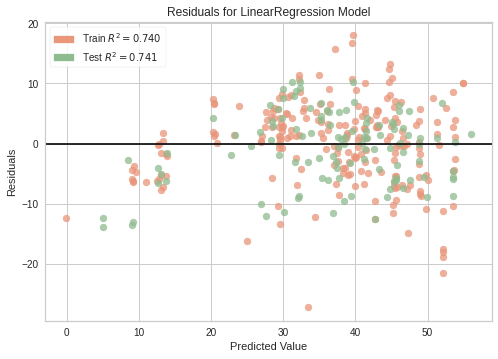

In [31]:
visualizer = ResidualsPlot(LinearRegression(), hist=False, train_color='darksalmon', test_color='darkseagreen')
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof() 

Goldfeld-Quandt homoscedasticity test
- examines whether the residual variance is the same in 2 subsamples
- null hypothesis assumes homoscedasticity (variance in the two sub-samples are the same)
- if p-value below 0.05,  the null hypothesis should be rejected in favor of heteroscedasticity

In [32]:
X_constant = sm.add_constant(X)
stat_ols_const = sm.OLS(y,X_constant).fit()
resids = stat_ols_const.resid

gq_test = sms.het_goldfeldquandt(resids, stat_ols_const.model.exog)[1]

print('Goldfeld-Quandt test')
if gq_test < 0.05:
  print('Heteroscedasticity with p-value =', gq_test)
else:
  print('Homoscedasticity with p-value =', gq_test)

Goldfeld-Quandt test
Homoscedasticity with p-value = 0.8058258620039864


Multicollinearity and auto-correlation overview

In [33]:
import statsmodels.api as sm

stat_ols = sm.OLS(y, X)
stat_ols = stat_ols.fit()
print(stat_ols.summary())

                                     OLS Regression Results                                    
Dep. Variable:     Y house price of unit area   R-squared (uncentered):                   0.972
Model:                                    OLS   Adj. R-squared (uncentered):              0.972
Method:                         Least Squares   F-statistic:                              2301.
Date:                        Mon, 08 Mar 2021   Prob (F-statistic):                   3.61e-255
Time:                                01:06:19   Log-Likelihood:                         -1111.5
No. Observations:                         337   AIC:                                      2233.
Df Residuals:                             332   BIC:                                      2252.
Df Model:                                   5                                                  
Covariance Type:                    nonrobust                                                  
                                        

Autocorrelation: Durbing-Watson test
- between 0 and 4
  - closer to 0: positive correlation
  - closer to 4: negative correlation
- test is approximately equal to 2*(1-r)
  - r equals zero indicates no correlation


In [34]:
Durbin_Watson = durbin_watson(stat_ols.resid)
r = 1 - Durbin_Watson/2

if round(r) == 0:
  print('Without auto-correlation')
else:
  print('With auto-correlation')

print('\nDurbin_Watson:', Durbin_Watson)
print('r = %f ~ %.f' % (r, round(r)))

Without auto-correlation

Durbin_Watson: 1.9718561231455463
r = 0.014072 ~ 0


Bibliography

- https://medium.com/@lauradamaceno/regress%C3%A3o-linear-6a7f247c3e29
- https://www.dataquest.io/blog/understanding-regression-error-metrics/
- https://towardsdatascience.com/verifying-the-assumptions-of-linear-regression-in-python-and-r-f4cd2907d4c0